In [1]:
#Assignment 4 STC710: Question 2
#import necessary packages
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif #for feature selection
from sklearn.feature_selection import VarianceThreshold
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix
#read in the dataset
loan_data=pd.read_csv('loan.data.csv')
loan_data.head()
#print(loan_data.dtypes)#checking for categorical variables


,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,643538,48349,65210,76.68,3,16092,51,51,20-12-1981,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,595627,55159,62972,88.93,72,16682,45,475,01-01-1976,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
2,586518,67882,113530,61.66,7,23091,51,5858,26-03-1992,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,491581,55613,69807,85.95,103,20285,86,6995,01-01-1997,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
4,614684,46249,67645,70.22,67,18129,45,1511,22-02-1980,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [3]:
#preprocess the data
loan_data=loan_data.dropna()
#convert date variables to date type
loan_data['DATE_OF_BIRTH'] = pd.to_datetime(loan_data['DATE_OF_BIRTH'],dayfirst=True, errors='coerce')
loan_data['DISBURSAL_DATE'] = pd.to_datetime(loan_data['DISBURSAL_DATE'],dayfirst=True, errors='coerce')

#converting string trype variables to numeric
def convert_to_months(text):
    if isinstance(text, str) and 'yrs' in text:
        try:
            years = int(text.split('yrs')[0].strip())
            months = int(text.split('yrs')[1].replace('mon', '').strip())
            return years * 12 + months
        except:
            return None
    return None
loan_data['AVERAGE_ACCT_AGE_MONTHS'] = loan_data['AVERAGE_ACCT_AGE'].apply(convert_to_months)
loan_data['CREDIT_HISTORY_LENGTH_MONTHS'] = loan_data['CREDIT_HISTORY_LENGTH'].apply(convert_to_months)

#encode categorical variables
loan_data["EMPLOYMENT_TYPE"] = loan_data["EMPLOYMENT_TYPE"].astype('category')
loan_data["EMP_TYPE"] = loan_data["EMPLOYMENT_TYPE"].cat.codes
loan_data["PERFORM_CNS_SCORE_DESCRIPTION"] = loan_data["PERFORM_CNS_SCORE_DESCRIPTION"].astype('category')
loan_data["CNS_SCORE_DESC_CODE"] = loan_data["PERFORM_CNS_SCORE_DESCRIPTION"].cat.codes

#drop the original categorical variables
loan_data=loan_data.drop(['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION'], axis=1)
loan_data = loan_data.drop(['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH'], axis=1)
loan_data.head()
print(loan_data.dtypes)

UNIQUEID                                        int64
DISBURSED_AMOUNT                                int64
ASSET_COST                                      int64
LTV                                           float64
BRANCH_ID                                       int64
SUPPLIER_ID                                     int64
MANUFACTURER_ID                                 int64
CURRENT_PINCODE_ID                              int64
DATE_OF_BIRTH                          datetime64[ns]
DISBURSAL_DATE                         datetime64[ns]
STATE_ID                                        int64
EMPLOYEE_CODE_ID                                int64
MOBILENO_AVL_FLAG                               int64
AADHAR_FLAG                                     int64
PAN_FLAG                                        int64
VOTERID_FLAG                                    int64
DRIVING_FLAG                                    int64
PASSPORT_FLAG                                   int64
PERFORM_CNS_SCORE           

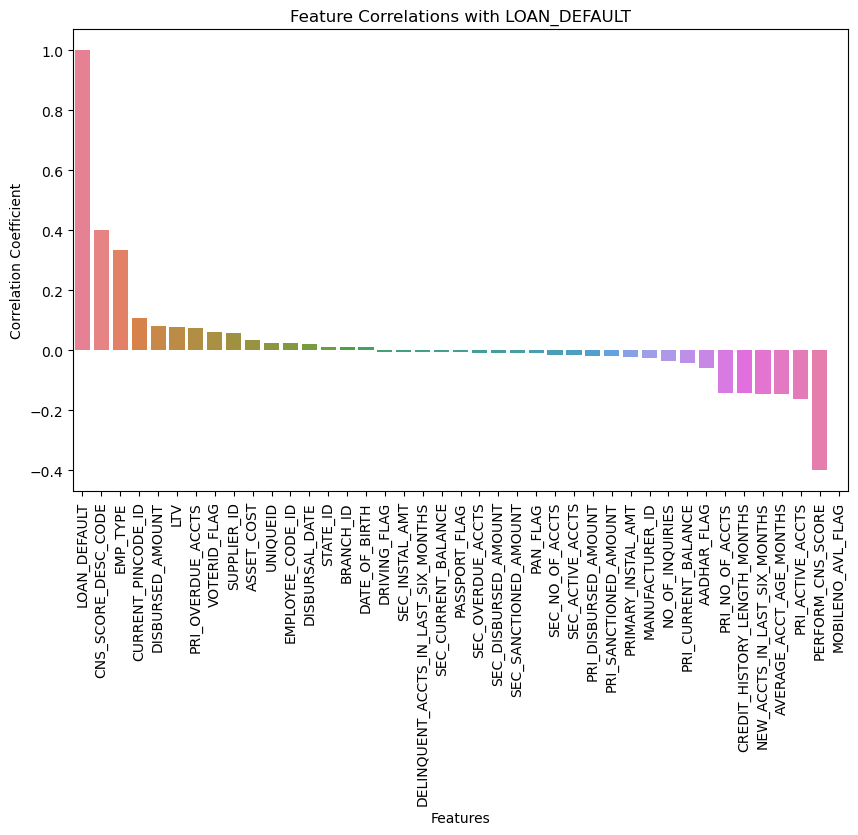

interval columns not set, guessing: ['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT', 'AVERAGE_ACCT_AGE_MONTHS', 'CREDIT_HISTORY_LENGTH_MONTHS', 'EMP_TYPE', 'CNS_SCORE_DESC_CODE', 'AGE_AT_DISBURSAL']


C:\Users\Taya\anaconda7\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable MOBILENO_AVL_FLAG for analysis 1. Dropping this column
  warnings.warn(


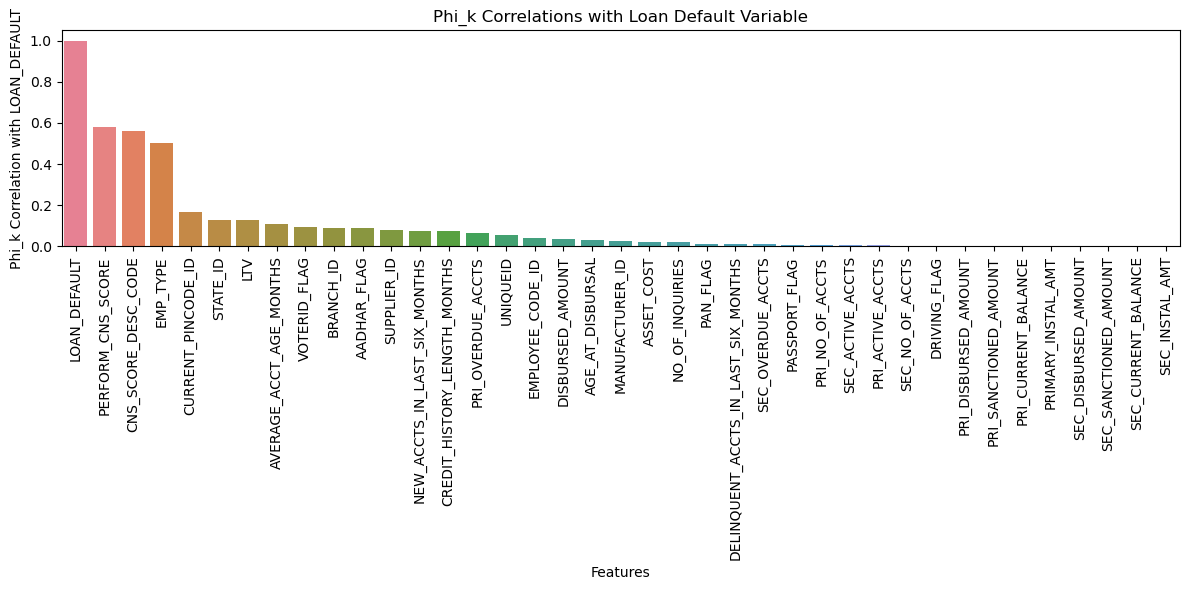

In [5]:
#Univariate feature selection
#split data for feature selection
Y=loan_data['LOAN_DEFAULT'] #loan_default is our binary response variable
X=loan_data.drop(columns='LOAN_DEFAULT')


#assess the correlations to see how strongly the features relate to the target
correlations = loan_data.corr()['LOAN_DEFAULT'].sort_values(ascending=False)

# Plotting the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, hue=correlations.index, legend=False)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.title('Feature Correlations with LOAN_DEFAULT')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

#Phik is designed to handle mixed variable types 
#phik cannot handle datetime type->convert to days since epoch->numeric
loan_data['DATE_OF_BIRTH'] = pd.to_datetime(loan_data['DATE_OF_BIRTH'], dayfirst=True, errors='coerce')
loan_data['DISBURSAL_DATE'] = pd.to_datetime(loan_data['DISBURSAL_DATE'], dayfirst=True, errors='coerce')

# Calculate age at the time of loan disbursal
loan_data['AGE_AT_DISBURSAL'] = (loan_data['DISBURSAL_DATE'] - loan_data['DATE_OF_BIRTH']).dt.days // 365
# Drop original datetime columns (optional)
loan_data.drop(columns=['DATE_OF_BIRTH', 'DISBURSAL_DATE'], inplace=True)

# Calculate the Phi_K correlation matrix
phik_corr = loan_data.phik_matrix()

# Extract correlations of features with the target variable 'LOAN_DEFAULT'
phik_target_corr = phik_corr['LOAN_DEFAULT'].sort_values(ascending=False) #sort our values

# Plot barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=phik_target_corr.index, y=phik_target_corr.values, hue=phik_target_corr.index, legend=False)
plt.xticks(rotation=90)
plt.ylabel('Phi_k Correlation with LOAN_DEFAULT')
plt.xlabel('Features')
plt.title('Phi_k Correlations with Loan Default Variable')
plt.tight_layout()
plt.show()

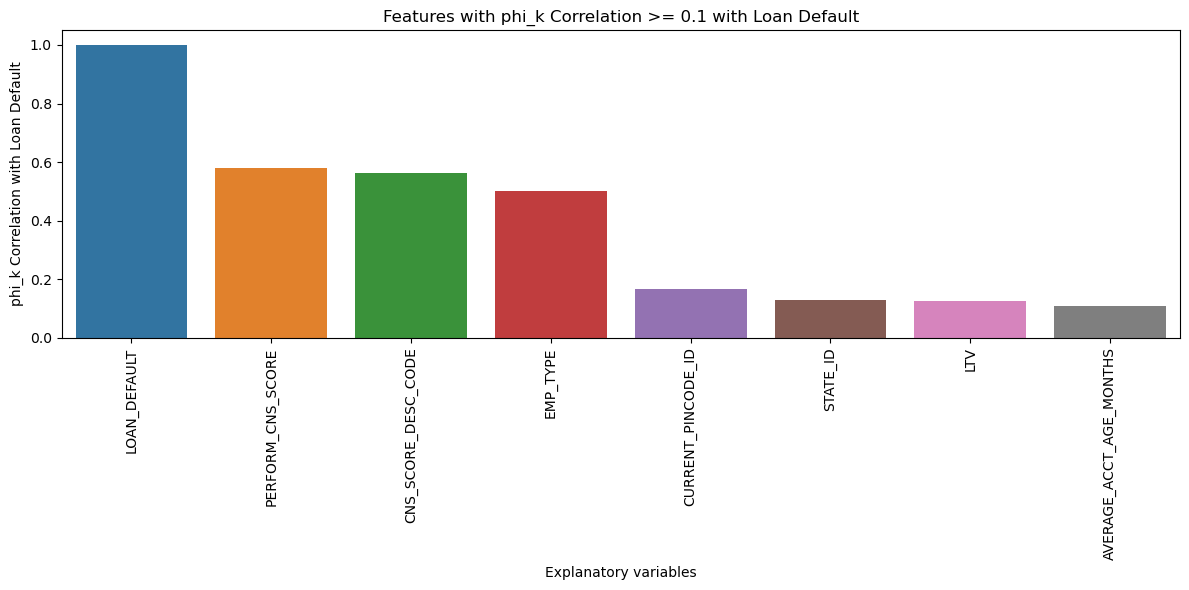

In [9]:
#remove variables with correlations weaker than 0.1
phik_target_corr_filtered = phik_target_corr[phik_target_corr.abs() >= 0.1]
plt.figure(figsize=(12, 6))
sns.barplot(x=phik_target_corr_filtered.index, y=phik_target_corr_filtered.values, hue=phik_target_corr_filtered.index, legend=False)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
plt.title('Features with phi_k Correlation >= 0.1 with Loan Default')
plt.xlabel('Explanatory variables')
plt.ylabel('phi_k Correlation with Loan Default')
plt.tight_layout()
plt.savefig('phi_k_loandefault')
plt.show()

Explained Variance:
[4.63728398e+00 3.53456055e+00 2.41041561e+00 2.09243258e+00
 1.81987429e+00 1.63800734e+00 1.56165353e+00 1.49316283e+00
 1.40093764e+00 1.36820551e+00 1.07130434e+00 1.02948390e+00
 1.01302950e+00 9.91764493e-01 9.76816705e-01 9.66433880e-01
 9.23884786e-01 9.00173383e-01 8.62993181e-01 8.49674959e-01
 7.72979889e-01 7.50116482e-01 7.05383661e-01 6.51112996e-01
 5.99531467e-01 5.35973551e-01 4.61885326e-01 3.69150948e-01
 1.62857373e-01 1.51563915e-01 1.22253986e-01 7.05069972e-02
 6.13025115e-02 2.94427897e-02 1.36812683e-02 2.69479861e-04
 1.81700150e-04 3.09999070e-32]
Total Explained Variance: 37.0003

Explained Variance Ratio:
[1.25331026e-01 9.55279218e-02 6.51458619e-02 5.65517927e-02
 4.91854097e-02 4.42701249e-02 4.22065244e-02 4.03554388e-02
 3.78628855e-02 3.69782400e-02 2.89539464e-02 2.78236732e-02
 2.73789630e-02 2.68042376e-02 2.64002465e-02 2.61196318e-02
 2.49696652e-02 2.43288214e-02 2.33239589e-02 2.29640098e-02
 2.08911861e-02 2.02732610e-02 1.

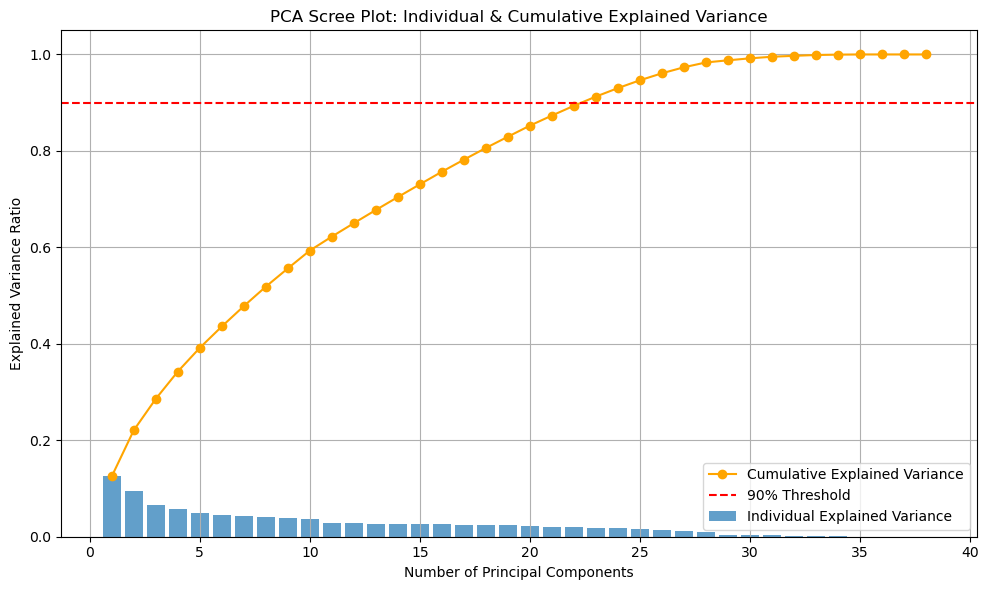

In [13]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = X.select_dtypes(exclude=['datetime'])
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
scaled = ss.fit_transform(X)

#perform PCA
pca=PCA(random_state=42)
pca_result=pca.fit_transform(scaled)

#explained variance
explained_variance = pca.explained_variance_
total_explained_variance = explained_variance.sum()
print(f"Explained Variance:\n{explained_variance}")
print(f"Total Explained Variance: {total_explained_variance:.4f}")

#explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()
print(f"\nExplained Variance Ratio:\n{explained_variance_ratio}")
print(f"Total Explained Variance Ratio: {total_explained_variance_ratio:.4f}")

#plot the scree plot
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker='o', color='orange', label='Cumulative Explained Variance')
# threshold line at 90% variance
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot: Individual & Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('screeplotq2.png')
plt.show()

In [63]:
print('We can see that around 23 componenets account for 90% of the total variance, as we want to avoid overfitting')

We can see that around 23 componenets account for 90% of the total variance, as we want to avoid overfitting
